In [2]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import splitfolders
from pathlib import Path
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F

# Use GPU
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up parameters
SEED = 309

IMG_SIZE = 360
ROT_SIZE = 90
TRAIN_PATH = './data/test'
TEST_PATH = './data/train'
BATCH = 4

LEARNING_RATE = 0.01
MOMENTUM = 0.9
N_EPOCHS = 2


In [4]:
# Perform Data Split
splitfolders.ratio('./origData', output="./data", seed=SEED, ratio=(.7, 0,0.3)) 

Copying files: 4418 files [00:01, 2814.91 files/s]


In [9]:
# function used for displaying images
# from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [10]:
# Read data


trainDataTransform = transforms.Compose( [
                         transforms.Resize((IMG_SIZE,IMG_SIZE)),
                         transforms.RandomRotation(ROT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor() ])
    
testDataTransform  = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                         transforms.ToTensor()])


train_folder = torchvision.datasets.ImageFolder(TRAIN_PATH, transform=trainDataTransform)
trainLoader = torch.utils.data.DataLoader(train_folder, shuffle=True, batch_size = BATCH)


classes = ('cherry', 'strawberry', 'tomato')

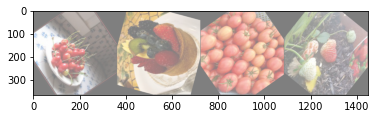

cherry strawberry tomato strawberry


In [11]:
# display images
train_iter = iter(trainLoader)
images, labels = next(train_iter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
# Conventional Neural Network for 3 Channels
# from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
KERNEL_SIZE = 3
PADDING = 0
STRIDE = 1

CHANNEL_OUT_1 = 32
CHANNEL_OUT_2 = 64
N_CLASSES = 3
N_CHANNELS = 3


class MLP(nn.Module):
    
    def __init__(self):
        super().__init__()        
        self.fc1 = nn.Linear(495616, CHANNEL_OUT_2) #dont change this nr idk why??? but it won't work without???
        self.fc2 = nn.Linear(CHANNEL_OUT_2, CHANNEL_OUT_1)
        self.fc3 = nn.Linear(CHANNEL_OUT_1, N_CLASSES)
       
        
    def forward(self, x):
        x = F.relu(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CNN_Net_1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(N_CHANNELS, CHANNEL_OUT_1, KERNEL_SIZE)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(CHANNEL_OUT_1, CHANNEL_OUT_2, KERNEL_SIZE)
        
        self.fc1 = nn.Linear(495616, CHANNEL_OUT_2) #dont change this nr idk why??? but it won't work without???
        self.fc2 = nn.Linear(CHANNEL_OUT_2, CHANNEL_OUT_1)
        self.fc3 = nn.Linear(CHANNEL_OUT_1, N_CLASSES)
       
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = nn.Softmax(x) # do it essentially propability between 0 and 1 for each class
        return x


net = CNN_Net_1()

In [13]:
# Loss function and optimizer
# from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.optim as optim

criterionLossFunction = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [ ]:
# Train the network
# also from  https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, surprise

for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # BUG [?]
        loss = criterionLossFunction(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
# SAVE MODEL

PATH = './MODEL_1.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
# Load train
# based on https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

test_folder  = torchvision.datasets.ImageFolder(TEST_PATH,  transform=testDataTransform)  
testLoader  = torch.utils.data.DataLoader(test_folder,  shuffle=True, batch_size = BATCH)

dataiter = iter(testLoader)
images, labels = next(dataiter)